# Mixture Model (Dummy data)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


# Load data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


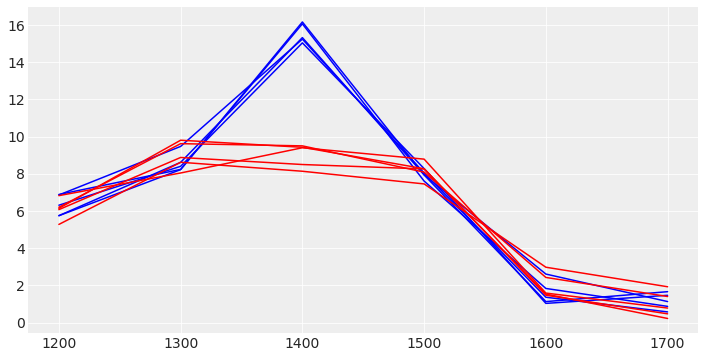

In [3]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'red'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [4]:
data.describe()

,1200,1300,1400,1500,1600,1700,code
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,6.205849,8.791261,12.280536,8.067198,1.792808,1.046804,1.500000
std,0.536333,0.631491,3.508007,0.374399,0.657708,0.558123,0.527046
min,5.276155,8.042763,8.136409,7.454639,1.028300,0.216872,1.000000
25%,5.828179,8.276819,9.406515,7.939410,1.386528,0.621489,1.000000
50%,6.169803,8.617580,12.271700,8.064990,1.556032,0.996962,1.500000
75%,6.695309,9.323373,15.304791,8.268090,2.276371,1.446952,2.000000
max,6.884220,9.805064,16.166272,8.787564,2.973493,1.923625,2.000000


In [5]:
# number of samples from each class
data['label'].value_counts()

Robusta    5
Arabica    5
Name: label, dtype: int64

# Model definition

In [6]:
# standardize data
x_n = data.columns[:-2]
x_s = data[x_n].values
#x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

In [7]:
# create array containin the label for each point
Y = data.iloc[:,-2].to_numpy()

Yl = np.full((len(x_s), len(x_n)), 0)
for i in range(len(x_s)):
    if (Y[i] == 1):
        Yl[i,:] = 1
    else:
        Yl[i,:] = 0

In [25]:
with pm.Model() as model_mm:
    # the modeled spectrum is a (1 x N) row vector of Gaussians
    mu_x = pm.Uniform('mu_x', 0, x_s.max())
    sigma_x = pm.Gamma('sigma_x', alpha=1., beta=1.)
    epsilon_x = pm.HalfNormal('epsilon_x', sigma_x)
    x_0 = pm.Normal('x_0', mu=mu_x, sd=epsilon_x, shape=len(x_n))
    x_1 = pm.Normal('x_1', mu=mu_x, sd=epsilon_x, shape=len(x_n))
    
    # labels 0 or 1 (observed from the data)
    theta = pm.Beta('theta', 1, 1)
    label = pm.Bernoulli('label', p=theta, observed=Yl) 
    
    # switch to spectrum 0 or 1 depending on the label
    x_ = pm.math.switch(pm.math.eq(label, 1), x_0, x_1)
    
    # random noise on top of observation
    sigma_n = pm.Gamma('sigma_n', alpha=1., beta=1.)
    epsilon = pm.HalfNormal('epsilon', sigma_n)
    
    x_pred = pm.Normal('x_pred', mu=x_, sd=epsilon, observed=x_s)
    
    trace_mm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_n, theta, x_1, x_0, epsilon_x, sigma_x, mu_x]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:10<00:00, 487.84draws/s]


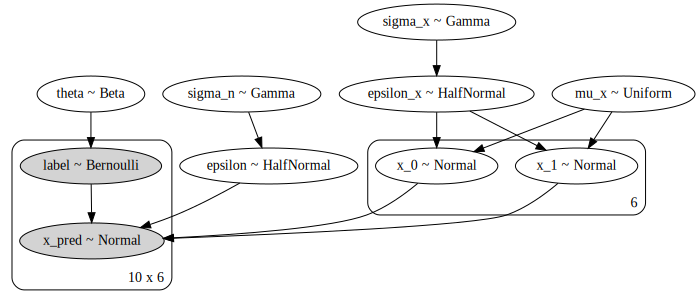

In [9]:
pm.model_to_graphviz(model_mm)

# Model evaluation

In [10]:
az.summary(trace_mm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x_0[0],6.310,0.262,5.796,6.779,0.003,0.002,9617.0,9617.0,9616.0,2473.0,1.0
x_0[1],8.579,0.257,8.091,9.078,0.003,0.002,10012.0,9980.0,10018.0,3152.0,1.0
x_0[2],15.530,0.265,15.043,16.031,0.003,0.002,7530.0,7489.0,7532.0,2336.0,1.0
x_0[3],7.957,0.267,7.432,8.434,0.003,0.002,8864.0,8864.0,8927.0,2635.0,1.0
x_0[4],1.607,0.254,1.139,2.081,0.003,0.002,9724.0,9724.0,9714.0,2616.0,1.0
x_0[5],1.162,0.264,0.663,1.680,0.003,0.002,8731.0,8373.0,8766.0,2908.0,1.0
x_1[0],6.104,0.263,5.600,6.585,0.003,0.002,7354.0,7287.0,7402.0,2737.0,1.0
x_1[1],8.983,0.266,8.493,9.493,0.003,0.002,9633.0,9633.0,9637.0,3060.0,1.0
x_1[2],8.983,0.265,8.486,9.488,0.003,0.002,8126.0,8078.0,8139.0,2997.0,1.0
x_1[3],8.163,0.259,7.671,8.638,0.003,0.002,8064.0,8064.0,8086.0,3003.0,1.0


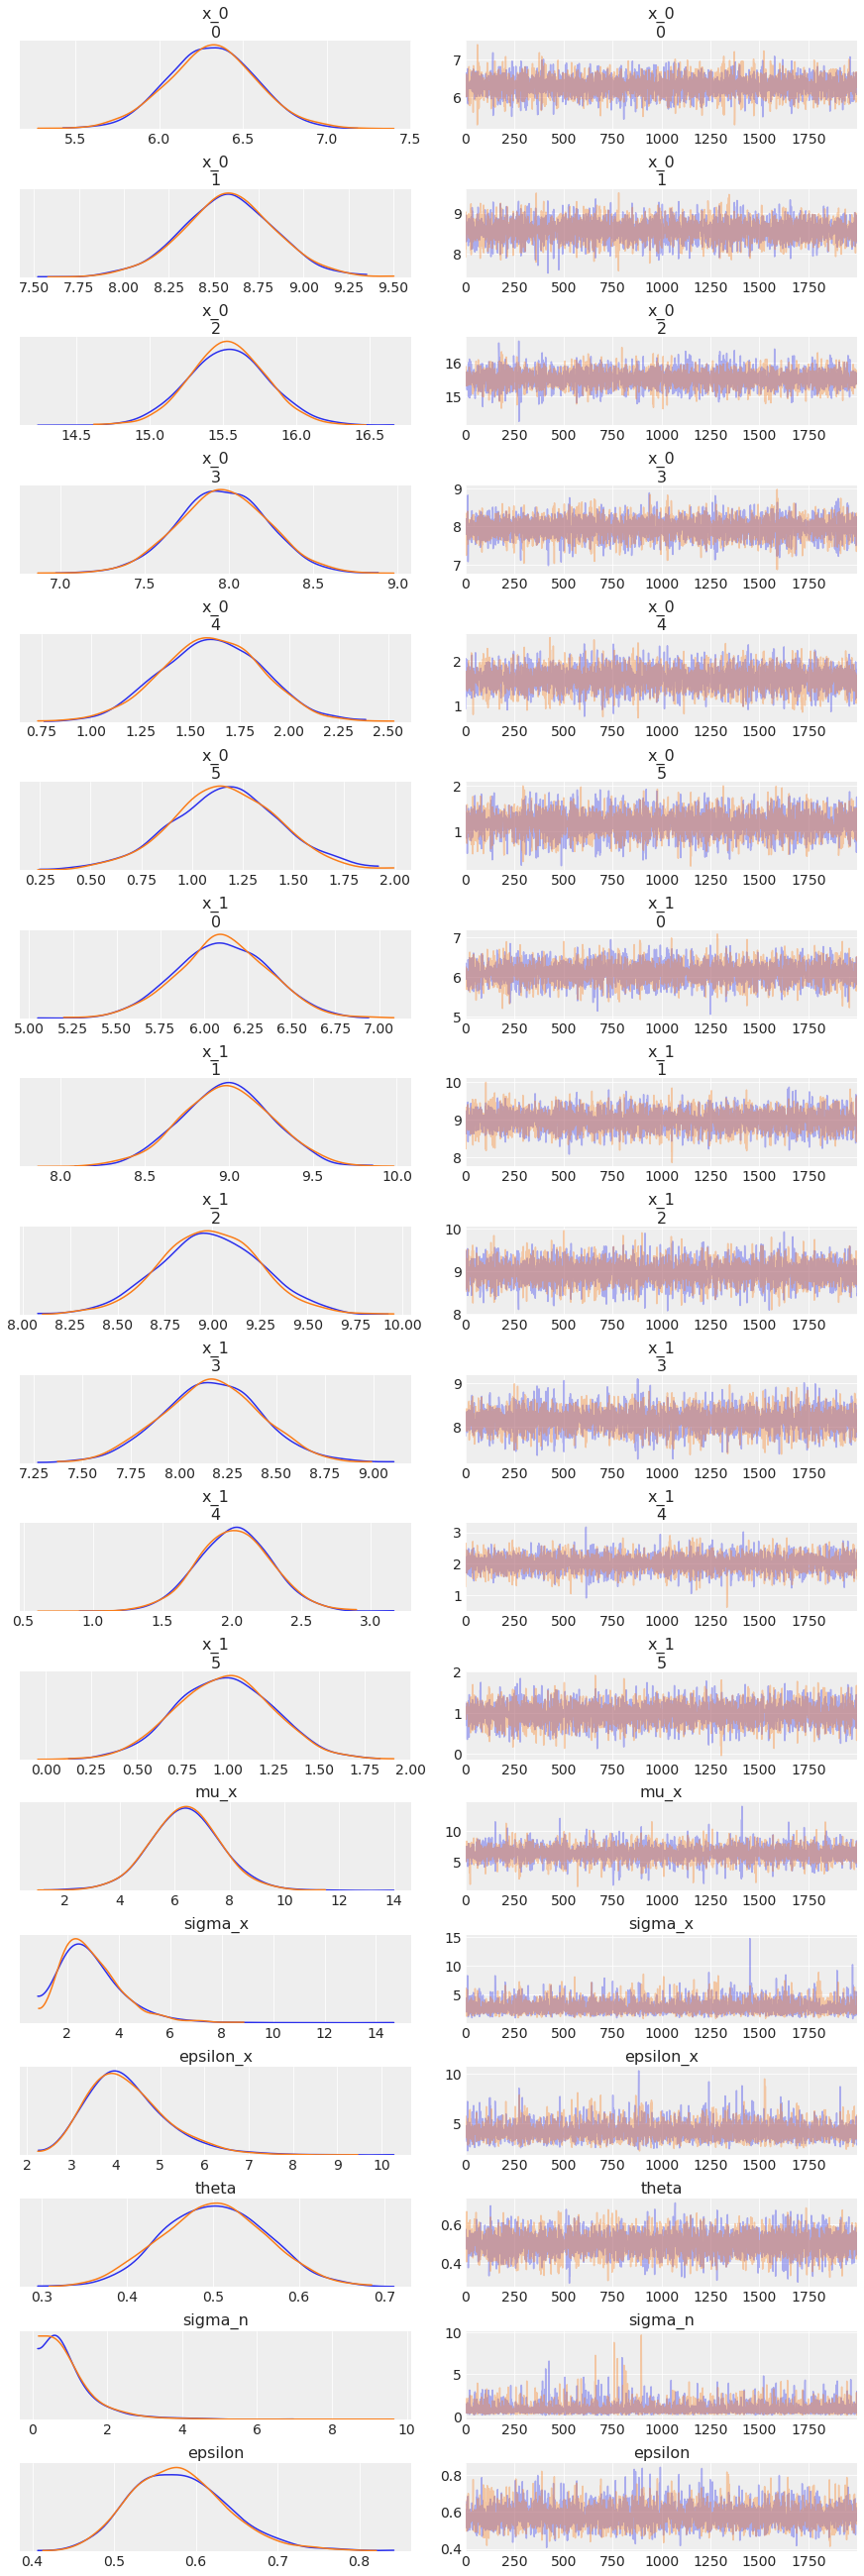

In [11]:
az.plot_trace(trace_mm);

In [12]:
#az.plot_posterior(trace_mm);

In [13]:
#az.plot_autocorr(trace_mm);

In [14]:
#az.plot_forest(trace_mm, combined=True);

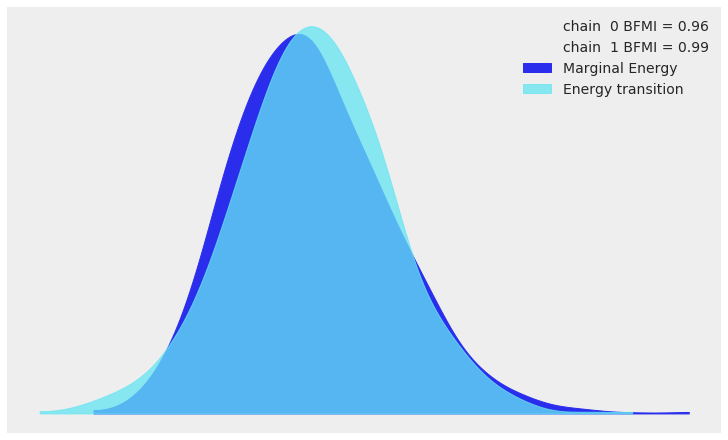

In [15]:
az.plot_energy(trace_mm, figsize=(10, 6));

In [16]:
ppc = pm.sample_posterior_predictive(trace_mm, samples=200, model=model_mm)

100%|██████████| 200/200 [00:00<00:00, 375.77it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


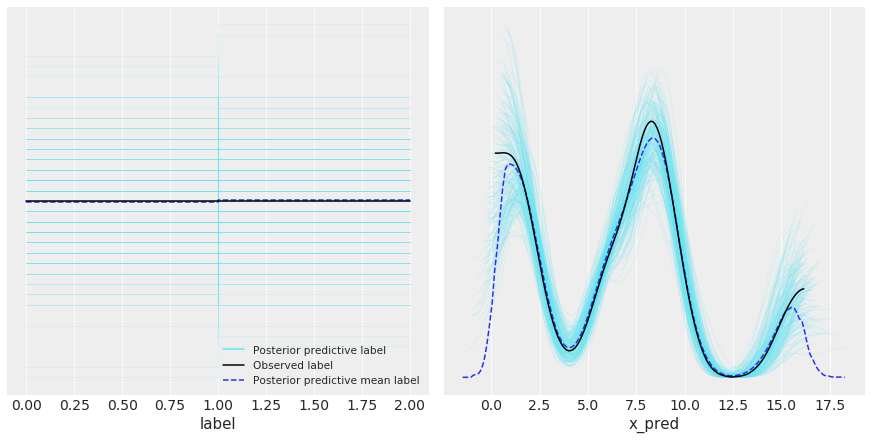

In [17]:
data_ppc = az.from_pymc3(trace=trace_mm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [20]:
az.r2_score(x_s, ppc['x_pred'])

r2        0.908662
r2_std    0.146797
dtype: float64

# Plot mean data and samples from the posterior

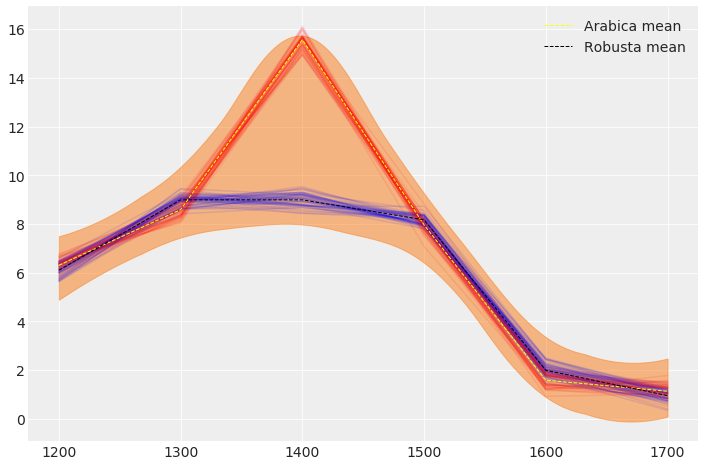

In [19]:
# spectrum samples from the posterior
sp1 = trace_mm['x_0']
sp2 = trace_mm['x_1']

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

for i in range(50):
    plt.plot(x_val, sp1[i], '-', color="red", alpha=0.1)
    plt.plot(x_val, sp2[i], '-', color="blue", alpha=0.1)

# get mean data for labels
df1 = data.loc[data['label'] == 'Arabica']
df1.iloc[:,:-2].mean()

df2 = data.loc[data['label'] == 'Robusta']
df2.iloc[:,:-2].mean()

plt.plot(x_val, df1.iloc[:,:-2].mean(), '--', color='yellow', 
         label='Arabica mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:-2].mean(), '--', color='black', 
         label='Robusta mean', linewidth=1)

az.plot_hpd(x_val, ppc['x_pred'], color='C1');

plt.legend(loc='best');